# Reader curation and error analysis

Reproducing Belief Engine figures for the paper:
* Log in to VPN
* `make output/fig4_reach_curve.pdf`
  * `output/fig4_reach_curve.pdf`
  * `output/fig4_sparser_curve.pdf`
  * `output/fig4_medscan_curve.pdf`
  * `output/table1_curation_dataset.tsv`
* For each reader, `python -m bioexp.curation.process_curations [reader] output`
** Regenerates the model fit results for the single reader models from curations in the DB
* `bioexp_paper/bioexp/curation/group_curations.py`
** Generates various curation dataset pickles from multiple reader curation tags in the DB
** Move these pickle files to this notebook directory
* This notebook
* `make deploy`


Figure 4 panels:
* Fig 4A: drawn
* Fig 4B, Table 1: `make output/fig4_reach_curve.pdf`, which runs `bioexp/figures/figure4/curated_correctness.py`
* Figure 4C: Made in LatexIt
* Figure 4D, Table 2: Run `bioexp/curation/process_curations.py` to generate fits; then run `bioexp/figures/figure4/model_fit_plots.py`
* Figure S4A (betabinomial and belief evidence fits): `bioexp/curation/process_curations.py`
* 4E (Upset plot): This notebook
* Figure S4B (Upset plot extended): This notebook
* Table 3 (Num readers frequency): This notebook
* Table 4 (Reader mention correlation): This notebook
* Figure 4F: This notebook
* Figure 4G: This notebook
* Figure S4C: This notebook
* Figure 4H: This notebook

## Summary

Interim summary of findings:

1. At the relation level, classifiers generate probabilities that are very close to the exact underlying joint probability distribution.

1. In the small data case, and especially the very small data case, Belief wins.

2. When there are only two readers, Belief does well (along with log-Logistic Regression), presumably because it explicitly captures information about correctness that is implied by the high counts. Binary random forests do poorly here.

3. On the other hand, binary random forests are the best in the baseline case of a full curation dataset where there are many readers (and presumably substantial but not total overlap). Belief is good (on par with Random Forests) but not the best.

4. Using more readers increases AUROC for all classifiers, which is a good justification of our multi-reader strategy.




## Introduction

Text mining is an increasingly effective tool for extracting structured information from the scientific literature for use in search, data analysis, and modeling (REFs). In the biomedical sciences, both commercial and non-commercial tools have been developed to extract many types of information, including protein-protein interactions (REFs), gene-disease relationships (REFs), and information on gene regulation and function (REFs). With growing interest in rapidly compiling systematic knowledge networks to accelerate discovery, especially in the context of emerging health crises such as COVID-19, interest in and applications of these natural language processing (NLP)  systems is likely to increase (REFs).

As the number and diversity of biomedical NLP systems has increased, it has become increasingly desirable to combine the results from more than one system to boost both the precision and recall of the information extracted. One of the key technical challenges in combining information is the need to estimate the reliability of extractions derived from multiple systems. Combining predictions from multiple classifiers is a well-established way of boosting performance in machine learning applications (REFs). Typically this is achieved by tuning the relative contributions of each classifier using a gold-standard dataset. However, in domains where training data is scarce, as is the case for many biomedical NLP tasks, systems may be based on deterministic rules or heuristics rather than supervised learning, making estimates of reliability difficult even for a single reading system. Even when combining systems based on supervised learning, the data used for the original training and validation may be sufficiently different from the target domain as to make assessments of recall and precision unreliable. This can occur when processing full-text articles after training only on abstracts, or transitioning to a very broad set of documents (e.g. all of PubMed) after training on only highly relevant documents.

In this paper we describe a straightforward approach to estimating joint extraction precision that only requires estimates of the precision of each component reader by assuming that reader errors are independent. These precision values can be based on limited manual curation or even *a priori* estimates. To demonstrate the approach, we obtained a corpus of relations by processing 570,000 scientific abstracts and full-texts with five different reading systems, and manually curated ~1,000 relations supported by ~5,000 underlying sentences for correctness. Using this dataset, we show that even though reader errors are *in fact* correlated, assuming error independence yields relation "belief scores" that, though not representing calibrated probabilities, nevertheless serve as a metric that can be used to adjust the false discovery rate in downstream applications. The receiver-operator characteristics of this approach are comparable to logistic regression and other classification methods, while requiring far less data. In real-world applications where reader overlap is minimal, belief scores are nearly as effective as exact knowledge of the joint probability distribution in separating correct from incorrect extractions.

## Results

### Article corpus, extracted relations, and curated dataset

For this study we defined a corpus of ~580,000 scientific articles enriched for information on protein interactions by searching the Entrez gene database for articles manually curated as relevant to one or more human genes (REF Entrez?). For these articles we obtained <span class="mark">XXX</span> abstracts and <span class="mark">YYY</span> full texts; abstracts were obtained from MEDLINE, full texts were obtained from either 1) the PubMed Central open access subset, 2) the PubMed author's manuscript collection, or 3) the Elsevier text and data mining API.

From these articles we combined extractions from five reading systems: REACH (REF), Sparser (REF), Medscan (REF), RLIMS-P (REF), and TRIPS (REF) and used the INDRA assembly system to normalize the resulting extractions into a consistent format (INDRA Ref). 81% of the assembled relations were obtained from only a single reading system, with the remaining 19% from two or more (<span class="mark">Tables 1 and 2 and Figure 1</span>).

In [2]:
# Imports.
import pickle
import random
import itertools
from os.path import join
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
from venn import venn
from numpy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from indra.tools import assemble_corpus as ac
from bioexp.curation.belief_models import *
from bioexp.util import format_axis, fontsize
from bioexp.curation.model_fit import ModelFit, ens_sample

import upsetplot

from bioexp.curation.classifiers import LogLogisticRegression, BinaryRandomForest

%matplotlib notebook


In [3]:
# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2021-05-13 13:06:40] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2021-05-13 13:07:37] indra.tools.assemble_corpus - Loaded 895580 statements


In [4]:
# Helper functions to save figures and tables
fig_ctr = 0
opath = '../output/'
prefix = 'fig4_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

def save_table(df, name):
    global fig_ctr
    fig_ctr += 1
    filename = join(opath, f'{prefix}_tbl_{fig_ctr}_{name}.xlsx')
    df.to_excel(filename)

In [5]:
# Filter out statements with None agents and those with only DB support.
# The list of readers: 
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
reader_abbrevs = {'reach': 'R', 'sparser': 'S', 'medscan': 'M',
                  'rlimsp': 'P', 'trips': 'T'}
reader_stmts = []
for stmt in tqdm(all_stmts):
    if None in stmt.agent_list():
        continue
    if not set([ev.source_api for ev in stmt.evidence]).intersection(set(reader_list)):
        pass
    else:
        reader_stmts.append(stmt)
    

100%|██████████| 895580/895580 [00:03<00:00, 290580.93it/s]


In [6]:
# Load and preprocess the curation dataset.

#curation_data_file = 'curation_dataset.pkl'
#curation_data_file = 'curation_dataset_with_bg_psp.pkl'
curation_data_file = join(opath, 'curation_dataset.pkl')
curation_data_file_inc = join(opath, 'curation_dataset_inc.pkl')
curation_data_with_supp_file = join(opath, 'curation_dataset_with_supp.pkl')

def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

def binarize_count_data(df):
    # First convert to true/false
    dtype_dict = {col: 'bool' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = df.astype(dtype_dict)
    # Then convert true/false into 1/0
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name',
                                 'agA_ns', 'agA_id', 'stmt_type', 'agB_name',
                                 'agB_ns', 'agB_id')}
    bin_df = bin_df.astype(dtype_dict)
    return bin_df

kge_df = load_curation_data(curation_data_file)
kge_df_inc = load_curation_data(curation_data_file_inc)
supp_df = load_curation_data(curation_data_with_supp_file)
bin_df = binarize_count_data(kge_df)

In [7]:
kge_df.shape

(1237, 21)

In [8]:
kge_df_inc.shape

(1330, 21)

In [9]:
# Table 1: Distribution of reader frequencies in corpus and curation data.
# (excluding database only statements)

def reader_set_to_tuple(rset, r_list, r_abbrevs):
    """Converts a frozen set of sources e.g. {reach, sparser} into a tuple 
       of the form (R, S, _, _, _) for use in displaying results."""
    rtup = []
    # Follow the order of readers in reader_list
    for r in r_list:
        if r in rset:
            rtup.append(r_abbrevs[r])
        else:
            rtup.append('_')
    return tuple(rtup)

def get_reader_freq_from_stmts(stmts, source_list, source_abbrevs):
    """Return dictionary showing frequency of reader combinations."""
    all_ev_cts = []
    # Get unique reader evidence sources for each statement
    for stmt in tqdm(stmts):
        sources = frozenset([ev.source_api for ev in stmt.evidence
                       if ev.source_api in source_list])
        if sources:
            all_ev_cts.append(sources)
    # Build up a dictionary mapping the reader combinations (as frozensets) to their
    # frequency in the set of statements
    all_ev_ctr = Counter(all_ev_cts)
    #all_ev_ctr_list = sorted([(k, (v / len(all_ev_cts)))
    #                          for k, v in all_ev_ctr.items()], key=lambda x: x[1], reverse=True)
    all_ev_ctr_dict = {reader_set_to_tuple(k, source_list, source_abbrevs):
                       (v / len(all_ev_cts)) for k, v in all_ev_ctr.items()}
    return all_ev_ctr_dict

def get_reader_counts_from_stmts(stmts):
    """Get a dataframe with source counts for each statement."""
    data = []
    for stmt in tqdm(stmts):
        ev_dict = dict(Counter([ev.source_api for ev in stmt.evidence]))
        ev_dict['stmt_hash'] = stmt.get_hash()
        ev_dict['stmt_type'] = stmt.__class__.__name__
        ev_dict['agA_name'] = stmt.agent_list()[0].name
        if len(stmt.agent_list()) == 2:
            ev_dict['agB_name'] = stmt.agent_list()[1].name
        else:
            continue
        data.append(ev_dict)
    df = pd.DataFrame(data).fillna(0)
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name')}
    return df.astype(dtype_dict)

def get_reader_freq_from_curation(df, col_list, r_abbrevs=None):
    """Build up dictionary of the proportions of each evidence combination in the
       curation dataset. Also return a mapping between the unique evidence combo
       and a dataframe with the curated statements for that combination."""
    if r_abbrevs is None:
        r_abbrevs = {c: c for c in col_list}
    df_ev_dict = {}
    total_rows = df.shape[0]
    df_subgroup_dict = {}
    for gb_key, gb_df in df.groupby(by=col_list):
        freq = (gb_df.shape[0] / total_rows) # Proportion of rows from this group
        label_set = frozenset([col for ix, col in enumerate(col_list)
                               if gb_key[ix] == 1])
        label_tup = reader_set_to_tuple(label_set, col_list, r_abbrevs)
        df_ev_dict[label_tup] = freq
        df_subgroup_dict[label_tup] = gb_df
    return (df_ev_dict, df_subgroup_dict)

def make_df(d, index_name, colname):
    """Build dataframe from a dictionary with dict keys as the index."""
    index, raw_cols = zip(*d.items())
    cols = tuple([c for c in raw_cols])
    index_obj = pd.Index(index, name=index_name, tupleize_cols=False)
    return pd.DataFrame(cols, columns=[colname], index=index_obj)

# -- reader_counts --
# Dataframe for statements with source counts for each statement in the corpus
reader_counts = get_reader_counts_from_stmts(reader_stmts)

# -- freq_df --
# A key result here is the freq_df, which gives the distribution of different reader
# combinations both in the whole corpus as well as in the curated dataset.

# First we need to get the reader/source frequencies (not counts!) from the statements:
reader_freqs = get_reader_freq_from_stmts(reader_stmts, reader_list, reader_abbrevs)
# We also want these for the curated statements to understand curation data bias
curation_freqs, curation_dfs = get_reader_freq_from_curation(bin_df, reader_list, reader_abbrevs)
# Make these into dataframes
stmt_freq_df = make_df(reader_freqs, 'Readers', 'Corpus Freq.')
cur_freq_df = make_df(curation_freqs, 'Readers', 'Curation Freq.')
# Join the above dataframes to make a single combined dataframe
freq_df = stmt_freq_df.join(cur_freq_df).sort_values('Corpus Freq.', ascending=False).fillna(0)
# Save and display
save_table(freq_df, 'freq')
freq_df

100%|██████████| 705022/705022 [00:01<00:00, 408612.53it/s]


,Corpus Freq.,Curation Freq.
Readers,,
"(R, _, _, _, _)",0.449950,0.136621
"(_, _, M, _, _)",0.201791,0.086500
"(_, S, _, _, _)",0.153938,0.029911
"(R, _, M, _, _)",0.078537,0.096200
"(R, S, _, _, _)",0.049878,0.063864
"(R, S, M, _, _)",0.028466,0.097009
"(_, S, M, _, _)",0.010037,0.010509
"(R, S, M, _, T)",0.005133,0.133387
"(_, _, _, _, T)",0.004401,0.049313


Generate data for reader overlap plots:

In [10]:
def stmts_by_source(stmts, source_list):
    """Get {reader: [stmt_uuids]} for all stmts and sources in source_list.
    
    Used to generate Venn diagram and UpSet plot.
    """
    reader_uuids = {}
    for stmt in stmts:
        stmt_sources = frozenset([ev.source_api for ev in stmt.evidence
                             if ev.source_api in source_list])
        # Skip statements with no sources in the given list
        if not stmt_sources:
            continue
        for source in stmt_sources:
            if source not in reader_uuids:
                reader_uuids[source] = set()
            reader_uuids[source].add(stmt.uuid)
    return reader_uuids

uuids_by_source = stmts_by_source(reader_stmts, reader_list)

Venn diagram of reader overlap:

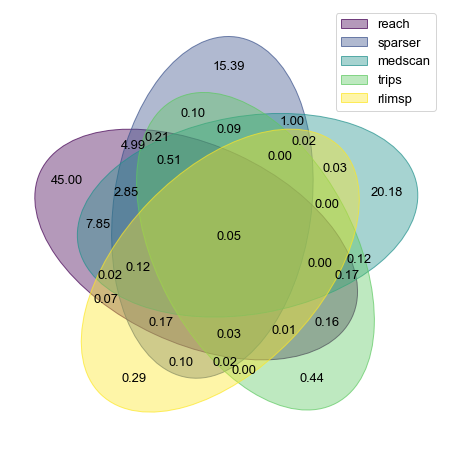

In [11]:
source_venn_subplot = venn(uuids_by_source, fmt='{percentage:.2f}')
source_venn_subplot.figure.savefig(fig_path('overlap_venn_pcts', 'pdf'))

Make an UpSet plot of the same data (both linear and log scale):

INFO: [2021-05-13 13:08:13] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2021-05-13 13:08:13] numexpr.utils - NumExpr defaulting to 8 threads.


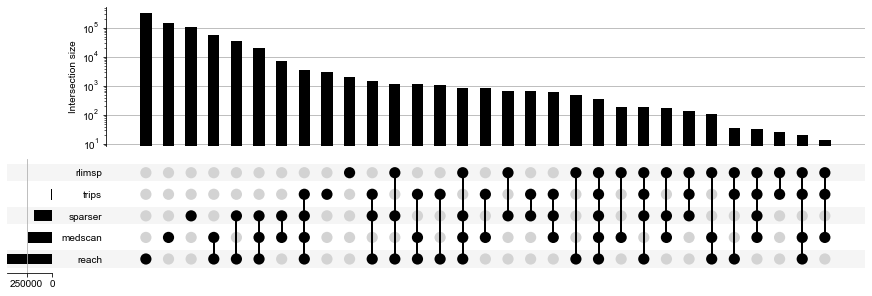

In [12]:
upset_df = upsetplot.from_contents(uuids_by_source)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
# Plot a linear scale version
upset_fig.savefig(fig_path('overlap_upset_linear', 'pdf'))
# Plot a log scale version
upset_fig.gca().set_yscale('log')
upset_fig.savefig(fig_path('overlap_upset_log', 'pdf'))

In [13]:
# Table 2: Frequencies of relations in corpus by total number of sources.
def marginal_reader_freqs(freqs):
    rcount_dict = {}
    for rtup, freq in freqs.items():
        # Count the number of readers in the freq key tuple
        # Make a set, then turn into a string, then replace'_' with nothing
        rstr = ''.join(set(rtup)).replace('_', '')
        rcount = len(rstr)
        if rcount not in rcount_dict:
            rcount_dict[rcount] = 0
        rcount_dict[rcount] += freq
    return rcount_dict

rcount_dict = marginal_reader_freqs(reader_freqs)
overlap_freq_df = make_df(rcount_dict, 'Num. readers', 'Freq.')
save_table(overlap_freq_df, 'overlap_freq')
overlap_freq_df

,Freq.
Num. readers,
1,0.813014
2,0.144215
3,0.035539
4,0.006722
5,0.000509


To evaluate different approaches to estimating the reliability we curated a corpus of relations drawn from each reader. For each of the five reading systems we sampled relations supported by between one and ten evidence sentences processed by that reader. For each relation, we manually reviewed each evidence sentence to determine whether it supported the relation extracted by the reader. A relation was determined to be "correct" if it was supported by at least one evidence sentence from any reader. The resulting dataset is comprised of ~1000 curated statements with ~5000 manually curated evidences. Because sampling was stratified both by reader and by the number of supporting sentences, the curated dataset has a substantially different reader distribution than the underlying corpus: for example, statements from TRIPS alone (which was only used to process a subset of abstracts: <span class="mark">see Methods</span>) accounted for only 0.8% of statements in the full corpus but 6.5% of statements in the curated dataset (Table 1).

### Correlations among readers at the mention and relation levels

Readers showed substantial correlation in the number of individual mentions they identified for a relation, with $\rho(Reach, Sparser)$ and $\rho(Reach, Medscan)$ > 0.6 (Table 3). However, the strong correlations among Reach, Sparser, and Medscan were driven by subset of relations with very high numbers of mentions, as shown by a scatter plot of mention counts for Reach and Sparser (Figure 2). Removing just the two outlying points with the largest numbers of mentions ("TNF activates NFkappaB" and "TP53 binds MDM2") reduced $\rho(Reach, Sparser)$ to 0.55 (Table 4). The likelihood of reader overlap is largely a function of the number of times a relation appears in the corpus, which can be seen using reader mentions as a proxy for underlying frequency (Figure 3).

In [14]:
# Table 3. Correlations among readers in mention counts.
mention_corrs = reader_counts[reader_list].corr()
save_table(mention_corrs, 'mention_corrs')
mention_corrs

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.610648,0.632608,0.071888,0.373680
sparser,0.610648,1.000000,0.453898,0.113957,0.419828
medscan,0.632608,0.453898,1.000000,0.033821,0.337839
rlimsp,0.071888,0.113957,0.033821,1.000000,0.095912
trips,0.373680,0.419828,0.337839,0.095912,1.000000


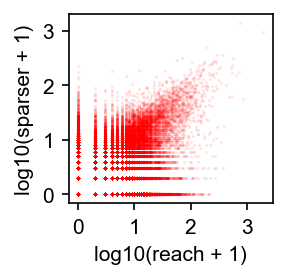

In [17]:
# Figure 2: Scatter plot of mention counts from Reach and Sparser.
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def reader_corr_plot(count_df, reader1, reader2, jitter=0.01, logscale=True):
    fig = plt.figure(figsize=(2, 2), dpi=150)
    #kge_cp  = count_df[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
    if logscale:
        r1_counts = np.log10(count_df[reader1] + 1)
        r2_counts = np.log10(count_df[reader2] + 1)
        xlabel = f'log10({reader1} + 1)'
        ylabel = f'log10({reader2} + 1)'        
    else:
        r1_counts = count_df[reader1].values
        r2_counts = count_df[reader2].values
        xlabel = reader1
        ylabel = reader2    
    plt.plot(rand_jitter(r1_counts, jitter),
             rand_jitter(r2_counts, jitter), linestyle='', marker='.', markersize=1,
             color='red', alpha=0.1, label='Correct')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.subplots_adjust(left=0.22, bottom=0.25)
    plt.xticks([0, 1, 2, 3])
    #plt.legend(loc='upper left', frameon=False)
    #plt.figtext(0.5, 0.01, "A figure legend.", wrap=True, horizontalalignment='center', fontsize=14)
    #plt.show()
    return fig
    
fig = reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=True)
fig.savefig(fig_path('reach_sparser_corrs', 'png'))


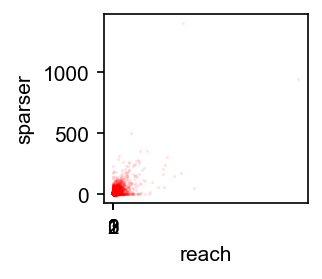

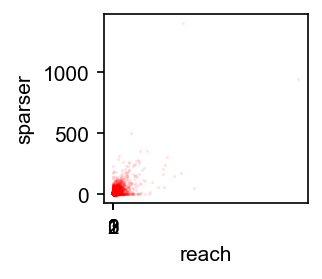

In [18]:
reader_corr_plot(reader_counts, 'reach', 'sparser', jitter=0, logscale=False)

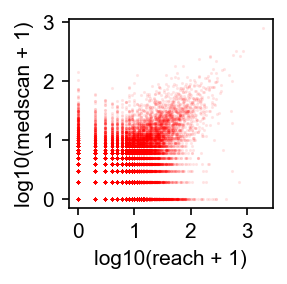

In [19]:
fig = reader_corr_plot(reader_counts, 'reach', 'medscan', jitter=0, logscale=True)
fig.savefig(fig_path('reach_medscan_corrs', 'png'))

In [20]:
# Table 4: Mention correlations after filtering out two outlying points with many mentions.
outliers = reader_counts[reader_counts['sparser'] > 800]
outlier_filt = reader_counts.drop(outliers.index)
outlier_filt[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,0.550781,0.548421,0.080636,0.325913
sparser,0.550781,1.000000,0.364867,0.132939,0.332754
medscan,0.548421,0.364867,1.000000,0.037220,0.290822
rlimsp,0.080636,0.132939,0.037220,1.000000,0.100157
trips,0.325913,0.332754,0.290822,0.100157,1.000000


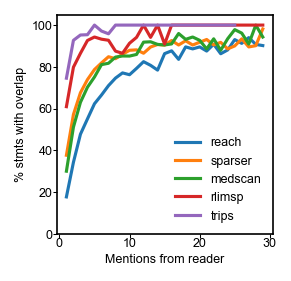

In [22]:
# Figure 3: Reader overlap as a function of mentions.
def plot_joint_vs_reader_count(count_df, reader_list):
    fig = plt.figure(figsize=(2, 2), dpi=150)
    for reader in reader_list:
        count_df = reader_counts
        other_readers = [r for r in reader_list if r != reader]
        x_vals = []
        y_vals = []
        for reader_count in range(1, 30):
            recs_for_count = count_df[count_df[reader] == reader_count]
            if recs_for_count.shape[0] == 0:
                continue
            x_vals.append(reader_count)
            y_vals.append(100*recs_for_count[other_readers].any(1).mean())
        plt.plot(x_vals, y_vals, label=reader)
    plt.xlabel(f'Mentions from reader')
    plt.ylabel(f'% stmts with overlap')
    plt.legend(loc='lower right', frameon=False, fontsize=fontsize)
    plt.ylim(0, 105)
    ax = plt.gca()
    format_axis(ax)
    plt.subplots_adjust(left=0.18, bottom=0.15)
    return fig

fig = plot_joint_vs_reader_count(reader_counts, reader_list)
fig.savefig(fig_path('overlap_vs_mentions', 'pdf'))

When mention counts were ignored and only the binary presence/absence of reader support was considered, correlations were small or moderately negative, because the readers contribute separately to the overall corpus but with little overlap on average (Table 5; also Table 1, Figure 1). This is most easily understood for the simplest case of a corpus with output from only two readers, where all correlations would be less than or equal to zero. If the readers were fully complementary (one reader yielding 1 for the other's 0 and vice versa) the correlation would clearly be -1; on the other hand, if the readers were in total agreement (produced identical output), the dataset would contain no zeros at all (because the corpus contains only relations with support from at least one reader) and hence the variances, covariances and correlations would all be zero.

In our dataset with five readers, the readers which produced the majority of the relations (Reach, Sparser, and Medscan) had only negative correlations with each other (Table 5), because the majority of their output was supported by one or two mentions (Table 6), and lacked overlap with other readers (Table 7). RLIMS-P and TRIPS exhibited positive correlations with other readers at the relation level, due to the fact that a large proportion of their overall smaller number of extractions overlapped with extractions from other readers (Table 7).

In [23]:
# Table 5: Correlations among readers at the relation level
bin_reader_counts = binarize_count_data(reader_counts)
bin_reader_counts[reader_list].corr()

,reach,sparser,medscan,rlimsp,trips
reach,1.000000,-0.241753,-0.474403,-0.020938,-0.015515
sparser,-0.241753,1.000000,-0.128048,0.078555,0.111548
medscan,-0.474403,-0.128048,1.000000,-0.010978,0.047709
rlimsp,-0.020938,0.078555,-0.010978,1.000000,0.069556
trips,-0.015515,0.111548,0.047709,0.069556,1.000000


In [24]:
# Table 6: Proportion of relations from each reader with 1 or >1 mentions.
def one_or_more_mentions(reader_counts, reader_list):
    nz = reader_counts[reader_list].apply(lambda x: x > 0, axis=0).sum()
    one = reader_counts[reader_list].apply(lambda x: x == 1, axis=0).sum()
    multi = reader_counts[reader_list].apply(lambda x: x > 1, axis=0).sum()
    one_ser = one / nz
    multi_ser = multi / nz
    one_ser.name = '=1 mention'
    multi_ser.name = '>1 mentions'
    return pd.concat([one_ser, multi_ser], axis=1)

one_or_more_mentions(reader_counts, reader_list)

,=1 mention,>1 mentions
reach,0.675077,0.324923
sparser,0.618371,0.381629
medscan,0.711481,0.288519
rlimsp,0.636058,0.363942
trips,0.833957,0.166043


In [25]:
# Table 7: Proportion of relations with overlap with other readers
def overlap_or_not(reader_counts, reader_list):
    col_names = ["No overlap", "Overlap"]
    no_ovl_data = []
    ovl_data = []
    for reader in reader_list:
        other_readers = [r for r in reader_list if r != reader]
        r_df = reader_counts[reader_counts[reader] != 0]
        overlap_pct = r_df[other_readers].any(1).mean()
        ovl_data.append(overlap_pct)
        no_ovl_data.append(1 - overlap_pct)
    return pd.DataFrame(zip(no_ovl_data, ovl_data), index=reader_list, columns=col_names)

overlap_or_not(reader_counts, reader_list)

,No overlap,Overlap
reach,0.724879,0.275121
sparser,0.501262,0.498738
medscan,0.610968,0.389032
rlimsp,0.300823,0.699177
trips,0.222587,0.777413


### Relation correctness as a function of reader overlap

We then examined the relationship between reader overlap and reader correctness using our manually curated dataset. At the mention level, statements supported by many mentions were both more likely to overlap with other readers and to be scored as correct (Figure 4). Notably, we found that for Reach, the reader with the most extensive subset of curated relations, the probability of relation correctness went up with the overall number of Reach mentions, but only for high-mention statements that also included support from other readers. For relations with support only from Reach, probability of correctness went up from 1 to 2 mentions, but additional Reach-only mentions were not associated with any further increase in precision (Figure 5).

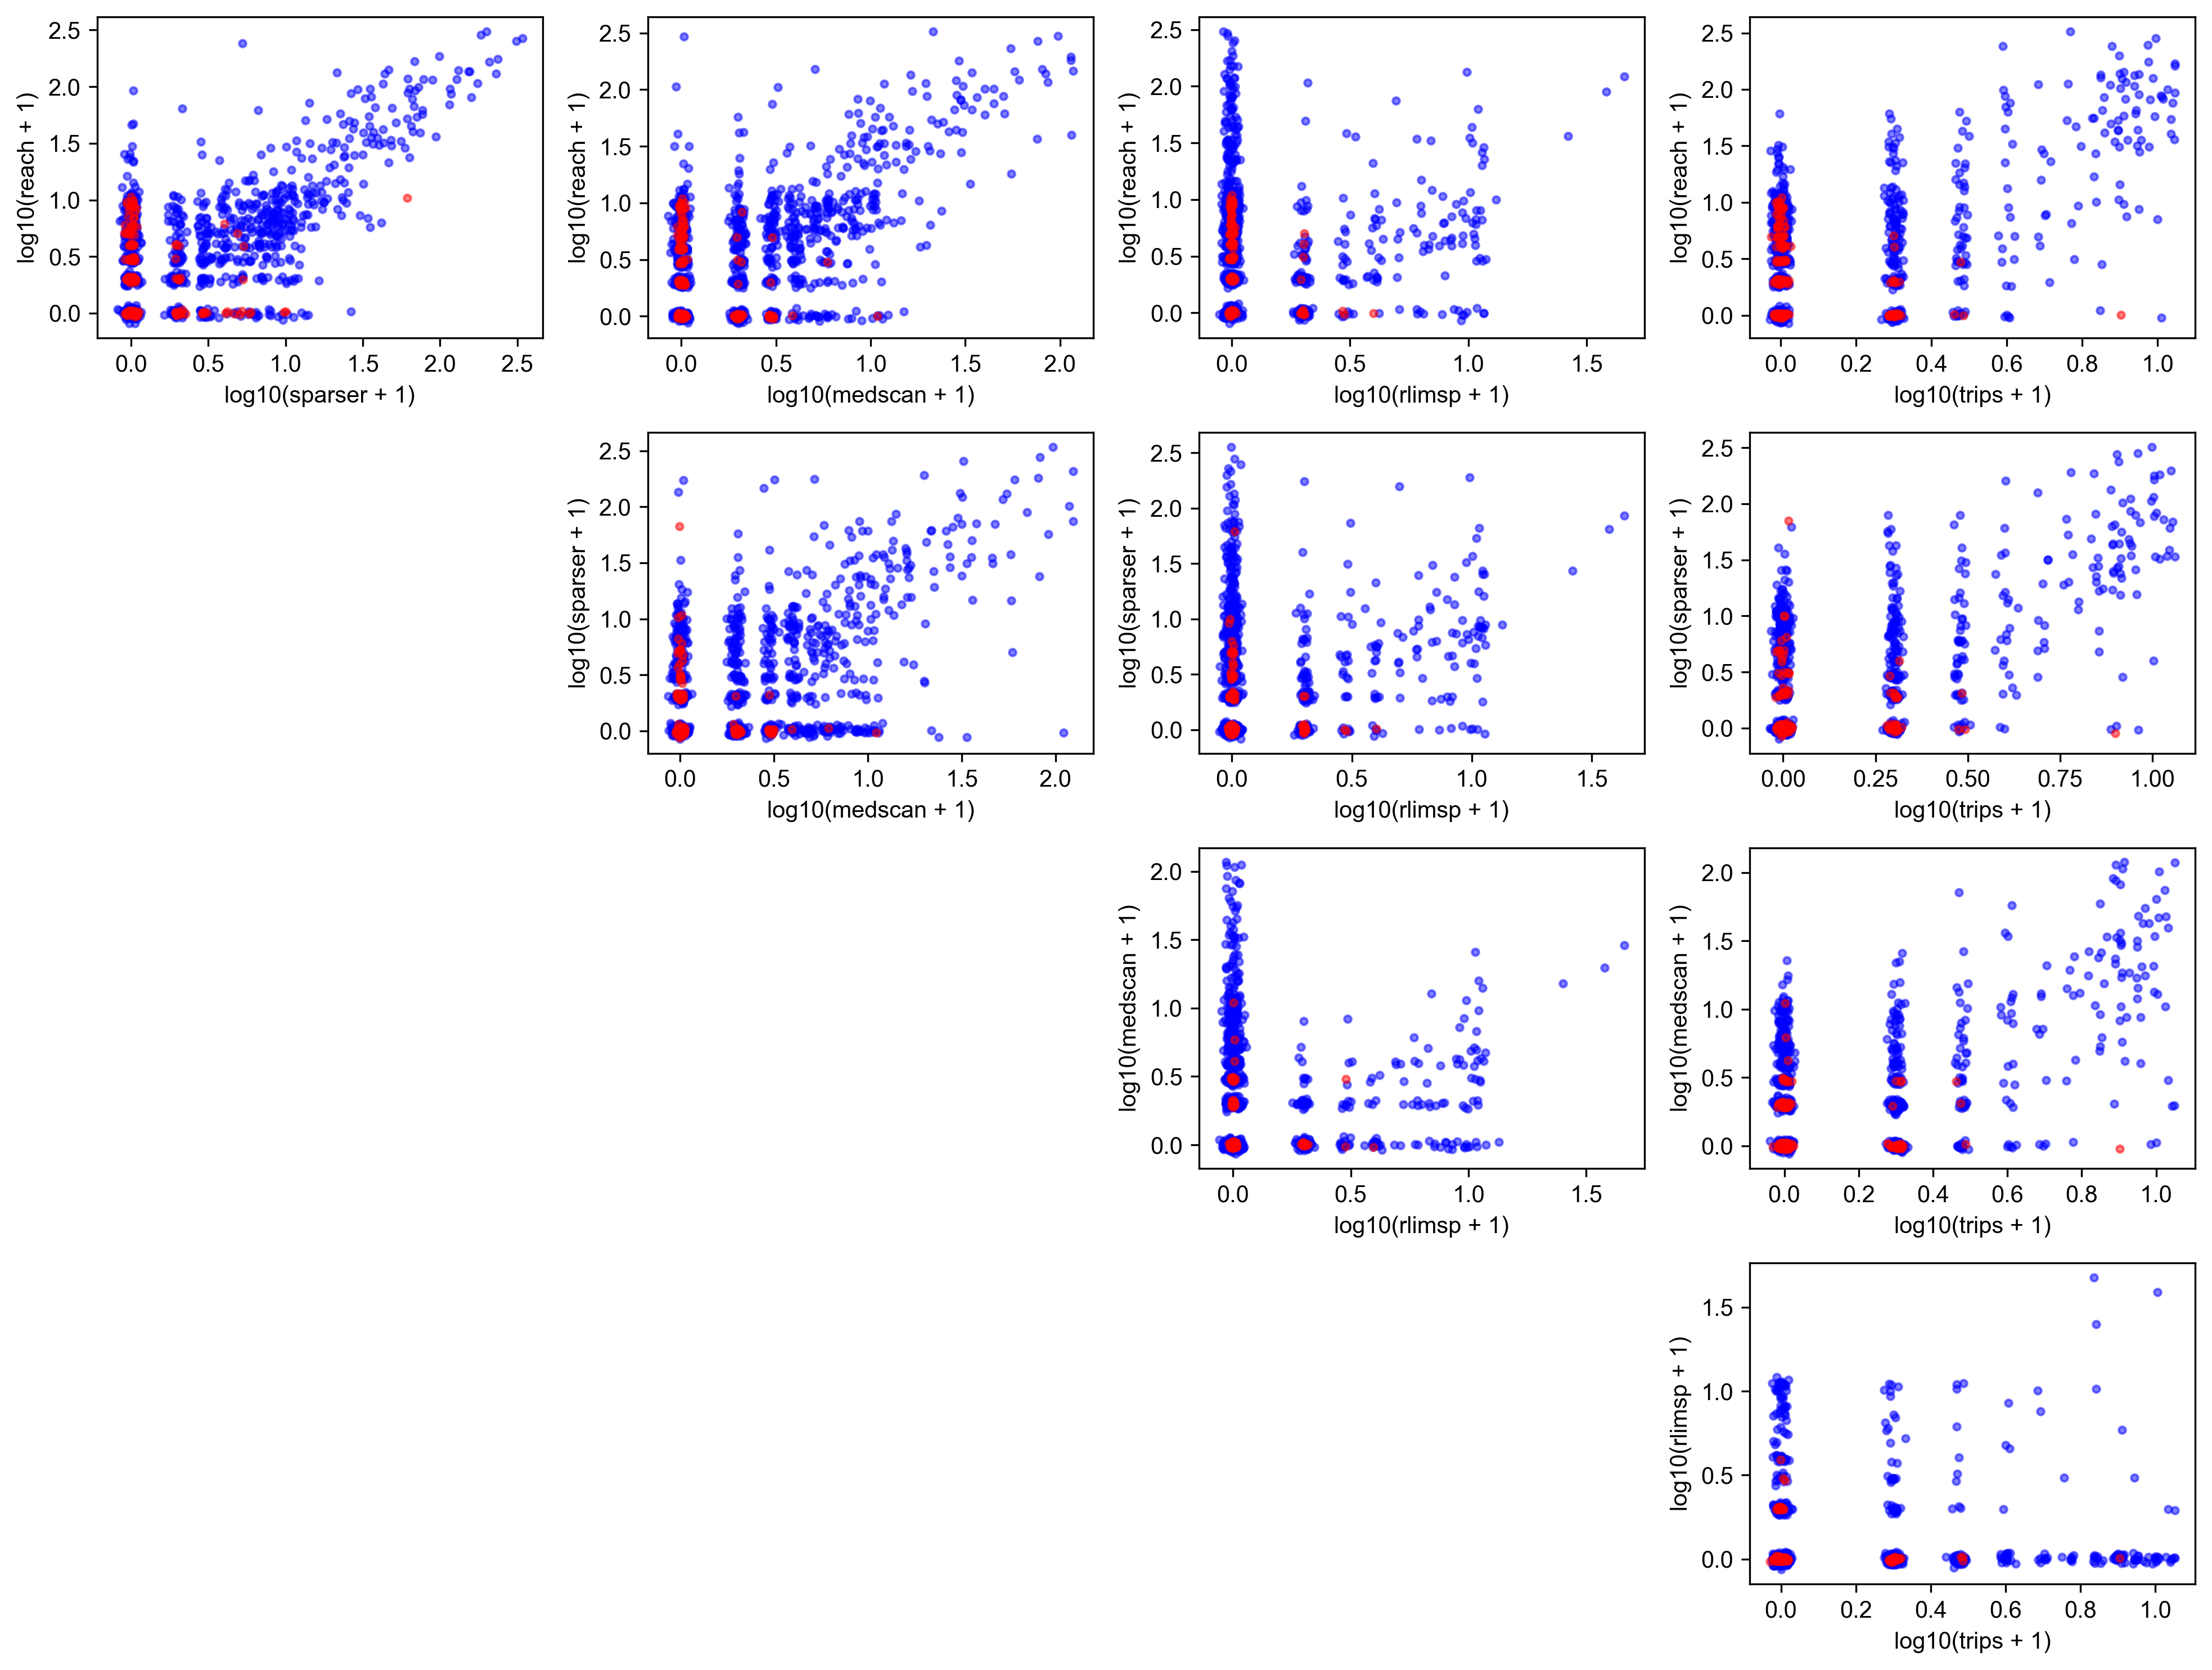

In [26]:
# Figure 4: Statement overlap at mention level and probability of correctness.
def plot_overlap_correctness(count_df, readers):
    r_pairs = list(itertools.product(readers, readers))
    plotted = set()
    fig = plt.figure(figsize=(16, 10), dpi=300)
    n_rows = len(readers) - 1
    n_cols = len(readers)
    for i, (reader1, reader2) in enumerate(r_pairs):
        fs_readers = frozenset((reader1, reader2))
        if reader1 == reader2 or fs_readers in plotted:
            continue
        plotted.add(fs_readers)
        plt.subplot(n_rows, n_cols, i+1)
        incorr = count_df[count_df['correct'] == 0]
        corr = count_df[count_df['correct'] == 1]
        for df, color, label in ((corr, 'blue', 'Correct'),
                                 (incorr, 'red', 'Incorrect')):
            r1_counts = np.log10(df[reader1] + 1)
            r2_counts = np.log10(df[reader2] + 1)
            plt.plot(rand_jitter(r2_counts),
                     rand_jitter(r1_counts), linestyle='', marker='.',
                     color=color, alpha=0.5, label=label)
        plt.xlabel(f'log10({reader2} + 1)')
        plt.ylabel(f'log10({reader1} + 1)')
    #plt.legend(loc='upper left')
    ax = plt.gca()
    #format_axis(ax)
    plt.tight_layout()
    return fig

fig = plot_overlap_correctness(kge_df, reader_list)
fig.savefig(fig_path('overlap_correctness', 'png'))

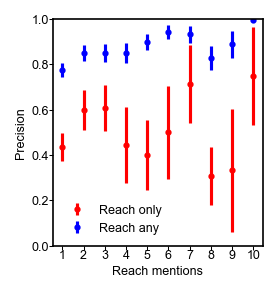

In [28]:
# Figure 5: Correctness vs. Reach mentions with and without reader overlap
def stderrp(p, n):
    pa = np.array(p)
    na = np.array(n)
    return(np.sqrt((pa*(1-pa))/na))

def reader_corr_vs_overlap(ct_df, reader, legend_loc):
    source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
                   'biopax', 'bel', 'signor', 'trrust']
    source_cols.pop(source_cols.index(reader))
    # Reader only dataframe
    ro_df = ct_df[~ct_df[source_cols].any(axis=1)]
    x = list(range(1, 11))
    r_only = []
    r_all = []
    r_only_cts = []
    r_all_cts = []

    for i in x:
        # Upper and lower bound for this group of counts: 1-9 and then 10+
        lb = i
        ub = i+1 if i < 10 else 10000

        r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
        r_only.append(r_only_rows['correct'].mean())
        r_only_cts.append(len(r_only_rows['correct']))
        r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
        r_all.append(r_all_rows['correct'].mean())
        r_all_cts.append(len(r_all_rows['correct']))

    fig = plt.figure(figsize=(2, 2), dpi=150)
    plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o',
                 markersize=2, color='r', label=f'{reader.capitalize()} only')
    plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o',
                 markersize=2, color='b', label=f'{reader.capitalize()} any')
    plt.legend(loc=legend_loc, fontsize=fontsize, frameon=False)
    plt.ylabel('Precision')
    plt.xlabel(f'{reader.capitalize()} mentions')
    plt.ylim([0, 1])
    ax = plt.gca()
    format_axis(ax)
    plt.xticks(x)
    plt.subplots_adjust(left=0.2)
    return fig

fig = reader_corr_vs_overlap(kge_df, 'reach', 'lower left')
fig.savefig(fig_path('reach_only_corr', 'pdf'))

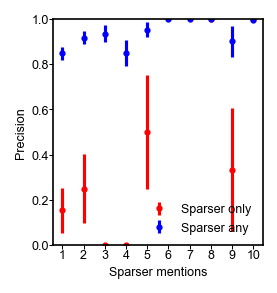

In [29]:
fig = reader_corr_vs_overlap(kge_df, 'sparser', 'lower right')
fig.savefig(fig_path('sparser_only_corr', 'pdf'))